In [1]:
# General
import numpy as np
import matplotlib.pyplot as plt

# For handling structures and visualizing structures
from ase import Atoms
from ase.build import graphene_nanoribbon
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io import read, write

# For MD
from ase.calculators.tersoff import Tersoff
from ase.constraints import FixAtoms
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase import units
from ase.neighborlist import neighbor_list

# Function for drawing atoms with atom indices and color depending MD constraint
def draw_atoms(atoms, radius=200, drawfixed=True):
    fig, ax = plt.subplots()

    # For drawing constraints
    if len(atoms.constraints) > 0:
        constraints = atoms.constraints[0].index
    else:
        constraints = []

    for ai, atom in enumerate(atoms):
        color = "k"
        if drawfixed and ai in constraints:
            color = "tab:red"
        ax.scatter(atom.position[2], atom.position[0], color=color, alpha=0.5, s=radius)
        ax.annotate(ai, (atom.position[2], atom.position[0]), ha="center", va="center", color="white")
    ax.set_xlim([0, atoms.cell[2,2]])
    ax.set_ylim([0, atoms.cell[0,0]])
    ax.set_xlabel("z, Å")
    ax.set_ylabel("x, Å")
    ax.axis("equal")
    return ax

# Function for loading and plotting temperature along MD trajectory
def plot_mdlog(fname="md.log"):
    log = np.loadtxt(fname, skiprows=1)
    fig, ax = plt.subplots()
    ax.plot(log[:,0], log[:, 4], color="k", alpha=0.5)
    ax.set_xlabel("Time, ps")
    ax.set_ylabel("Temperature, K")
    return ax

# Function for sorting if needed
def sort_atoms(atoms):
    pos = atoms.get_positions()
    sorted_indices = np.lexsort((pos[:, 0], pos[:, 1], pos[:, 2]))
    return atoms[sorted_indices]

### Hamiltonian in this project

Nearest neighbor tight-binding with on-site $\epsilon=0$ eV and hopping $t = t_0 (d_0/d)^2$, where $t_0=-2.7$ eV and $d_0$ is the equilibrium bond length and $d$ is the actual bond length between two orbitals.
With thermal vibrations in molecular dynamics, the $d$ is going to vary and therefore the hopping elements of the Hamiltonian.

### Create unit cell (here graphene nanoribbon)

Vary these parameters and plot bands/transmission:
* The type of ribbon "kind"
* Width of ribbon "n"

If you want to consider PBC and k-sampling, feel free to consider doing graphene (instead of nanoribbons). The graphene Hamiltonian is a little trickier due to the PBC, however, the molecular dynamics will be slightly easier for graphene since there are no free edges that we need to fix (more on that later).

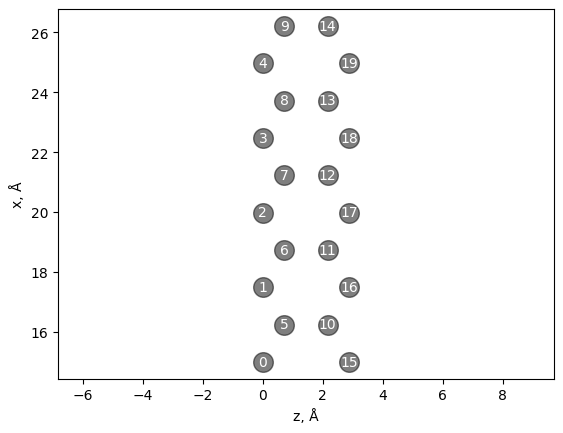

In [2]:
kind = "armchair"     # "armchair" or "zigzag"
n = 5                 # width parameter
length = 1            # periodic repetitions along z, i.e., transport direction here
vacuum = 15.0         # vacuum in non-periodic directions (Å)
bond = 1.43877067     # Optimized using C.tersoff potential discussed below

ribbon = graphene_nanoribbon(n=n,
                             m=length,
                             type=kind,
                             C_C=bond,
                             vacuum=vacuum)
ribbon.pbc = True
ribbon = sort_atoms(ribbon)
draw_atoms(ribbon)

structure = ribbon

In [3]:
# view(ribbon)

### First study band structure and transmission in pristine/static system

#### Band structure

In [12]:
#Functions:
eta = 0.01  # Small imaginary part for causality/broadening
def self_energy_decimation(energy, h0, V, iterations=100, tol=1e-9, print_check=False):
    """
    Calculates surface Green's function and Self Energy using the 
    Sancho-Rubio Decimation method (matches the image logic).
    
    Converges exponentially fast (doubles chain length each step).
    """
    size = h0.shape[0]
    I = np.eye(size)
    
    # t corresponds to hopping V in your notation
    t = V 
    t_dag = np.conjugate(np.transpose(V))
    
    # eps is the surface energy term we are updating
    eps_s = h0.copy()
    # eps is the bulk energy term
    eps = h0.copy()
    
    for _ in range(iterations):
        # Green's function for the bulk element being removed
        g = np.linalg.inv(energy * I - eps)
        
        # Update surface energy (connecting to the rest of the chain)
        eps_s = eps_s + t @ g @ t_dag
        
        # Update bulk energy and hopping parameters for the next iteration
        # This effectively calculates h^(1), V^(1) shown in your image
        eps_new = eps + t @ g @ t_dag + t_dag @ g @ t
        t_new = t @ g @ t 
        t_dag_new = t_dag @ g @ t_dag
        
        
        # Check for convergence (if hopping goes to zero, we are disconnected)
        if np.max(np.abs(t_new)) < tol:
            if print_check==True:
                print(f"Converged after {_+1} iterations.")
                break
            elif print_check==False:
                break

        eps = eps_new
        t = t_new
        t_dag = t_dag_new
            

        

    # The surface Green's function is the inverse of the effective surface Hamiltonian
    Gs = np.linalg.inv((energy + 1j * eta) * I - eps_s)
    Gb = np.linalg.inv((energy + 1j * eta) * I - eps)
    
    # Calculate Sigma from Gs: Sigma = zI - h0 - Gs^-1
    # Alternatively, specifically for the surface term: Sigma = t_initial @ G_bulk_surface @ t_dag_initial
    # But often directly calculating Sigma via the relation to Gs is easier:
    Sigma_s = eps_s - h0
    Sigma_b = eps - h0
    return Sigma_s, Sigma_b, Gs, Gb


#V^dagger
def V_dagger(V):
    return np.conjugate(np.transpose(V))

#Plot the real and imaginary parts of the green's function as a function of energy
def greens_function_vs_energy(H_onsite, V, energy_range, eta=0.01, print_check=False):
    real_parts = []
    imag_parts = []
    real_bulk_parts = []
    imag_bulk_parts = []
    
    size = H_onsite.shape[0]
    I = np.eye(size)

    for E in energy_range:
        z = E + 1j * eta  # Small imaginary part for causality/broadening
        
        # Use the self-energy from decimation to get the semi-infinite result
        Sigma, no,  Gs, Gb = self_energy_decimation(z, H_onsite, V,iterations=100, print_check=print_check)
        
        
        real_parts.append(np.real(Gs[0,0]))
        imag_parts.append(np.imag(Gs[0,0]))
        real_bulk_parts.append(np.real(Gb[0,0]))
        imag_bulk_parts.append(np.imag(Gb[0,0]))
    
    return real_parts, imag_parts , real_bulk_parts, imag_bulk_parts


#Plot LDOS
def LDOS(H_onsite, V, energy_range, eta=0.01):
    ldos_values = []
    ldos_bulk_values = []
    size = H_onsite.shape[0]
    I = np.eye(size)

    for E in energy_range:
        z = E + 1j * eta
        # Calculate surface Green's function for semi-infinite chain using decimation
        Sigma_s, Sigma_b, Gs, Gb = self_energy_decimation(z, H_onsite, V, iterations=100)
        
        G_trace = np.trace(Gs, axis1=0, axis2=1)
        ldos = -1/np.pi * np.imag(G_trace)
        ldos_values.append(ldos)

        Gb_trace = np.trace(Gb, axis1=0, axis2=1)
        ldos_bulk = -1/np.pi * np.imag(Gb_trace)
        ldos_bulk_values.append(ldos_bulk)
    return ldos_values, ldos_bulk_values

#Make a function
def transmission_vs_energy(H_device, hamil_R, V_R, hamil_L, V_L, energy_range, eta=0.0001):
    transmission_values = []
    size = H_device.shape[0]
    I = np.eye(size)

    for E in energy_range:
        z = E + 1j * eta
        
        # Get Surface Green's Functions for semi-infinite leads
        # Right Lead: Extends to +x. We need surface GF at left end. Decimation uses hopping *into* bulk (+x)
        # lead_hopping_into_right should be hopping from cell n to n+1
        sig_s_R, _, g_surface_R, _ = self_energy_decimation(z, hamil_R, V_R, iterations=100)
        
        # Left Lead: Extends to -x. We need surface GF at right end. Decimation uses hopping *into* bulk (-x)
        # lead_hopping_into_left should be hopping from cell n to n-1
        sig_s_L, _, g_surface_L, _ = self_energy_decimation(z, hamil_L, V_L, iterations=100)
        
        
        device_zero = np.zeros((size, size), dtype = complex)
        #Place the self energies in the top left and bottom right corners
        gray_left = device_zero.copy()
        small_size = g_surface_L.shape[0]
        gray_left[:small_size, :small_size] = sig_s_L
        gray_right = device_zero.copy()
        small_size = g_surface_R.shape[0]
        gray_right[-small_size:, -small_size:] = sig_s_R

        #Add the self energies to the device hamiltonian
        H_D = H_device + gray_left + gray_right
        
        #Gamma matricies: gamma_L = i * (Sigma_L - Sigma_L_dag)
        big_size = H_D.shape[0]
        gamma_L = 1j * (gray_left - V_dagger(gray_left))
        gamma_R = 1j * (gray_right - V_dagger(gray_right))
              
        #Greens function G_D
        G_D = np.linalg.inv(z*I - H_D)

        #Transmission T = Trace(Gamma_L @ G_D @ Gamma_R @ G_D_dag)
        T_value = np.real(np.trace(gamma_L @ G_D @ gamma_R @ V_dagger(G_D)))
        transmission_values.append(np.real(T_value))
    
    return transmission_values


--- Matrix Shapes ---
H_L: (5, 5)
H_D: (10, 10)
H_R: (5, 5)
t_L (Device-Left interface): (5, 5)
t_R (Device-Right interface): (5, 5)


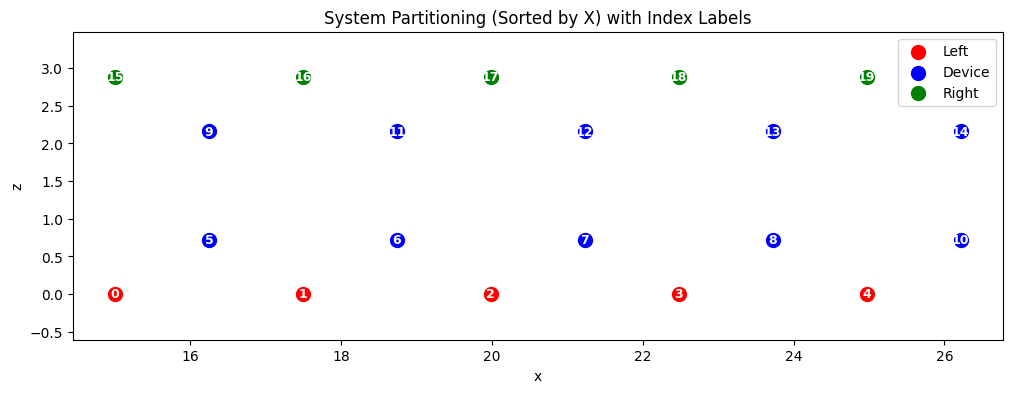

In [27]:
a = 1.42 # C-C bond length 

molecule = ribbon
def hamiltonian(xyz):
    dist = np.linalg.norm(xyz[None, :, :] - xyz[:, None, :], axis=2)
    return np.where((dist < (a + 0.1)) & (dist > 0.1), -1, 0)
#Sort numbering along x direction
sorted_indices = np.argsort(molecule.positions[:, 0])
sorted_positions = molecule.positions[sorted_indices]
H_gra = hamiltonian(sorted_positions)
#Then sort along z direction within same x

sorted_positions = sorted_positions[np.lexsort((sorted_positions[:, 2], sorted_positions[:, 0]))]
H_gra = hamiltonian(sorted_positions)

# Select all atoms in the molecule
indices = np.arange(len(molecule))

# Get positions from the molecule object
positions = molecule.positions[indices]

# --- New Code to Split Hamiltonian ---

# 1. Get positions of the active atoms from the molecule
# We use the 'indices' defined in the previous cell (which selects all atoms)
pos = molecule.positions[indices]

# 2. Sort atoms by their z-coordinate first, then x-coordinate (transport direction)
# This returns indices into the 'pos' (and 'H') array, not the original 'molecule' indices
x_sort_args = np.lexsort((pos[:, 0], pos[:, 2]))

# Manually swap atoms 9 and 10 as requested
x_sort_args[[9, 10]] = x_sort_args[[10, 9]]

# 3. Define Leads and Device
# Assuming the leads are the ends of the nanoribbon.
# n_lead_atoms depends on the width of the ribbon.
n_lead_atoms = 5

if len(pos) <= 2 * n_lead_atoms:
    raise ValueError(f"System too small (N={len(pos)}) to separate into Left, Device, Right with lead size {n_lead_atoms}.")

# Indices in the H matrix corresponding to each region
# (Note: These are indices 0..N-1 relative to the sub-matrix H, not the global atom indices)
idx_L = x_sort_args[:n_lead_atoms]
idx_R = x_sort_args[-n_lead_atoms:]
idx_D = x_sort_args[n_lead_atoms:-n_lead_atoms]

# 4. Extract Matrices
H_full = hamiltonian(pos) # Calculate Hamiltonian using the molecule's positions

# Hamiltonian Blocks
H_L = H_full[np.ix_(idx_L, idx_L)]      # Hamiltonian Left
H_D = H_full[np.ix_(idx_D, idx_D)]      # Hamiltonian Device
H_R = H_full[np.ix_(idx_R, idx_R)]      # Hamiltonian Right

# Hopping Matrices (Coupling between regions)
# We limit these to the interface atoms (n_lead_atoms) so they are 4x4 matrices
# t_L connects the left-most atoms of Device to Left Lead
t_L = H_full[np.ix_(idx_D[:n_lead_atoms], idx_L)]      

# t_R connects the right-most atoms of Device to Right Lead
t_R = H_full[np.ix_(idx_D[-n_lead_atoms:], idx_R)]      

print("--- Matrix Shapes ---")
print(f"H_L: {H_L.shape}")
print(f"H_D: {H_D.shape}")
print(f"H_R: {H_R.shape}")
print(f"t_L (Device-Left interface): {t_L.shape}")
print(f"t_R (Device-Right interface): {t_R.shape}")

# 5. Visualize the Partition
plt.figure(figsize=(12, 4))
plt.scatter(pos[idx_L, 0], pos[idx_L, 2], c='red', label='Left', s=100)
plt.scatter(pos[idx_D, 0], pos[idx_D, 2], c='blue', label='Device', s=100)
plt.scatter(pos[idx_R, 0], pos[idx_R, 2], c='green', label='Right', s=100)

# Add atom indices labels
for i, idx in enumerate(x_sort_args):
    plt.text(pos[idx, 0], pos[idx, 2], str(i), fontsize=9, ha='center', va='center', color='white', fontweight='bold')

plt.title("System Partitioning (Sorted by X) with Index Labels")
plt.xlabel("x")
plt.ylabel("z")
plt.legend()
plt.axis('equal')
plt.show()


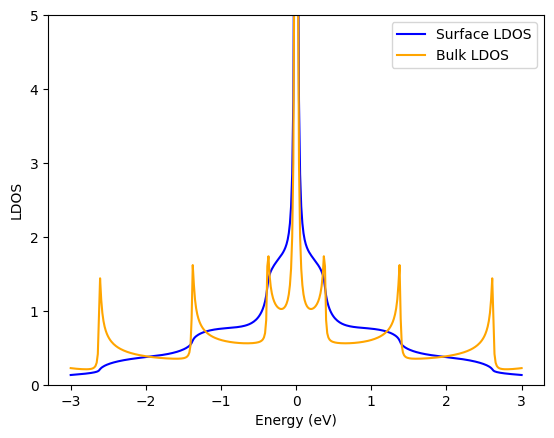

In [31]:
energy_range = np.linspace(-3, 3, 400)
ldos_values, ldos_bulk_values = LDOS(H_L, t_R, energy_range)
fig, ax = plt.subplots()
ax.plot(energy_range, ldos_values, label='Surface LDOS', color='blue')
ax.plot(energy_range, ldos_bulk_values, label='Bulk LDOS', color='orange')
ax.set_ylim(0, 5)
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('LDOS')
ax.legend()


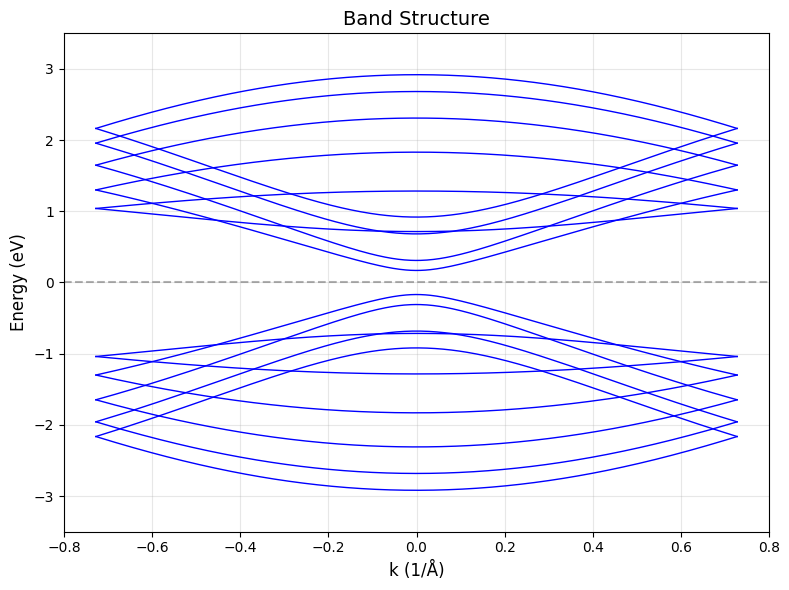

In [39]:
# Calculate band structure
def calculate_bands(structure, n_kpoints=300):
    """
    Calculate band structure for a periodic system along z-direction
    """
    # Get lattice constant in transport direction (z)
    lattice_z = structure.cell[2, 2]
    
    # Create k-points along the Brillouin zone
    k_points = np.linspace(-np.pi/lattice_z, np.pi/lattice_z, n_kpoints)
    
    # Get positions
    pos = structure.positions
    n_atoms = len(pos)
    
    # Neighbor parameters
    a = 1.42  # C-C bond length
    bond_min = 0.1
    bond_max = a + 0.1
    
    # Storage for bands
    bands = []
    
    for k in k_points:
        # Build H(k) using Bloch's theorem
        H_k = np.zeros((n_atoms, n_atoms), dtype=complex)
        
        for i in range(n_atoms):
            for j in range(n_atoms):
                # Check neighbors in 0, +1, and -1 unit cells
                for m in [-1, 0, 1]:
                    # Vector from atom i to atom j in image m
                    # R_vector is the lattice vector shift: [0, 0, m * lattice_z]
                    shift = np.array([0, 0, m * lattice_z])
                    diff_vec = pos[j] + shift - pos[i]
                    dist = np.linalg.norm(diff_vec)
                    
                    if bond_min < dist < bond_max:
                        # Found a neighbor!
                        # The hopping term is t = -1
                        # The Bloch phase factor depends on the lattice vector R = m * lattice_z
                        # H(k) = sum_R H(R) * exp(i * k * R)
                        
                        phase = np.exp(1j * k * (m * lattice_z))
                        H_k[i, j] += -1.0 * phase

        # Diagonalize to get eigenvalues (energies)
        eigenvalues = np.linalg.eigvalsh(H_k)
        bands.append(eigenvalues)
    
    return k_points, np.array(bands)

# Calculate bands
k_points, bands = calculate_bands(ribbon, n_kpoints=400)

# Plot band structure
fig, ax = plt.subplots(figsize=(8, 6))
for band_idx in range(bands.shape[1]):
    ax.plot(k_points, bands[:, band_idx], 'b-', linewidth=1)

ax.set_xlabel('k (1/Å)', fontsize=12)
ax.set_ylabel('Energy (eV)', fontsize=12)
ax.set_title('Band Structure', fontsize=14)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.set_ylim(-3.5, 3.5)  # Set y-axis limits to see the structure better
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Transmission function (of pristine/static structure)

Number of atoms (and orbitals) in unit cell: 20


<AxesSubplot: xlabel='z, Å', ylabel='x, Å'>

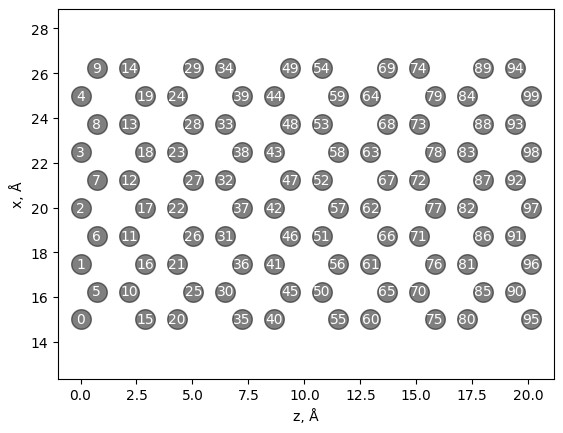

In [7]:
Ntransport = 5 # number of repetitions in transport direction (z). To create simple [L|L|C|R|R] geometry.
pristine_structure = structure.repeat((1, 1, Ntransport))

natom_elec = len(structure)
print("Number of atoms (and orbitals) in unit cell:", natom_elec)

draw_atoms(pristine_structure)

--- Matrix Shapes ---
H_L: (20, 20)
H_D: (60, 60)
H_R: (20, 20)
t_L (Device-Left interface): (20, 20)
t_R (Device-Right interface): (20, 20)


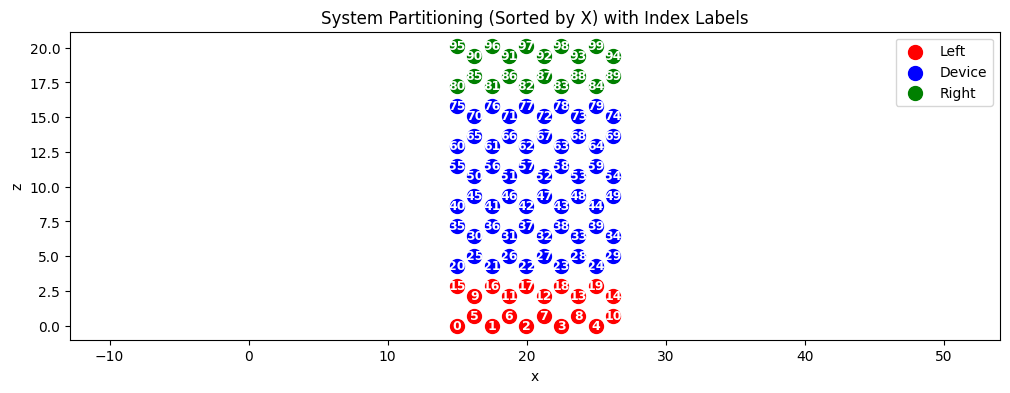

In [36]:
a = 1.42 # C-C bond length 

molecule = pristine_structure
def hamiltonian(xyz):
    dist = np.linalg.norm(xyz[None, :, :] - xyz[:, None, :], axis=2)
    return np.where((dist < (a + 0.1)) & (dist > 0.1), -1, 0)
#Sort numbering along x direction
sorted_indices = np.argsort(molecule.positions[:, 0])
sorted_positions = molecule.positions[sorted_indices]
H_gra = hamiltonian(sorted_positions)
#Then sort along z direction within same x

sorted_positions = sorted_positions[np.lexsort((sorted_positions[:, 2], sorted_positions[:, 0]))]
H_gra = hamiltonian(sorted_positions)

# Select all atoms in the molecule
indices = np.arange(len(molecule))

# Get positions from the molecule object
positions = molecule.positions[indices]

# --- New Code to Split Hamiltonian ---

# 1. Get positions of the active atoms from the molecule
# We use the 'indices' defined in the previous cell (which selects all atoms)
pos = molecule.positions[indices]

# 2. Sort atoms by their z-coordinate first, then x-coordinate (transport direction)
# This returns indices into the 'pos' (and 'H') array, not the original 'molecule' indices
x_sort_args = np.lexsort((pos[:, 0], pos[:, 2]))

# Manually swap atoms 9 and 10 as requested
x_sort_args[[9, 10]] = x_sort_args[[10, 9]]

# 3. Define Leads and Device
# Assuming the leads are the ends of the nanoribbon.
# n_lead_atoms depends on the width of the ribbon.
n_lead_atoms = 20

if len(pos) <= 2 * n_lead_atoms:
    raise ValueError(f"System too small (N={len(pos)}) to separate into Left, Device, Right with lead size {n_lead_atoms}.")

# Indices in the H matrix corresponding to each region
# (Note: These are indices 0..N-1 relative to the sub-matrix H, not the global atom indices)
idx_L = x_sort_args[:n_lead_atoms]
idx_R = x_sort_args[-n_lead_atoms:]
idx_D = x_sort_args[n_lead_atoms:-n_lead_atoms]

# 4. Extract Matrices
H_full = hamiltonian(pos) # Calculate Hamiltonian using the molecule's positions

# Hamiltonian Blocks
H_L = H_full[np.ix_(idx_L, idx_L)]      # Hamiltonian Left
H_D = H_full[np.ix_(idx_D, idx_D)]      # Hamiltonian Device
H_R = H_full[np.ix_(idx_R, idx_R)]      # Hamiltonian Right

# Hopping Matrices (Coupling between regions)
# We limit these to the interface atoms (n_lead_atoms) so they are 4x4 matrices
# t_L connects the left-most atoms of Device to Left Lead
t_L = H_full[np.ix_(idx_D[:n_lead_atoms], idx_L)]      

# t_R connects the right-most atoms of Device to Right Lead
t_R = H_full[np.ix_(idx_D[-n_lead_atoms:], idx_R)]      

print("--- Matrix Shapes ---")
print(f"H_L: {H_L.shape}")
print(f"H_D: {H_D.shape}")
print(f"H_R: {H_R.shape}")
print(f"t_L (Device-Left interface): {t_L.shape}")
print(f"t_R (Device-Right interface): {t_R.shape}")

# 5. Visualize the Partition
plt.figure(figsize=(12, 4))
plt.scatter(pos[idx_L, 0], pos[idx_L, 2], c='red', label='Left', s=100)
plt.scatter(pos[idx_D, 0], pos[idx_D, 2], c='blue', label='Device', s=100)
plt.scatter(pos[idx_R, 0], pos[idx_R, 2], c='green', label='Right', s=100)

# Add atom indices labels
for i, idx in enumerate(x_sort_args):
    plt.text(pos[idx, 0], pos[idx, 2], str(i), fontsize=9, ha='center', va='center', color='white', fontweight='bold')

plt.title("System Partitioning (Sorted by X) with Index Labels")
plt.xlabel("x")
plt.ylabel("z")
plt.legend()
plt.axis('equal')
plt.show()


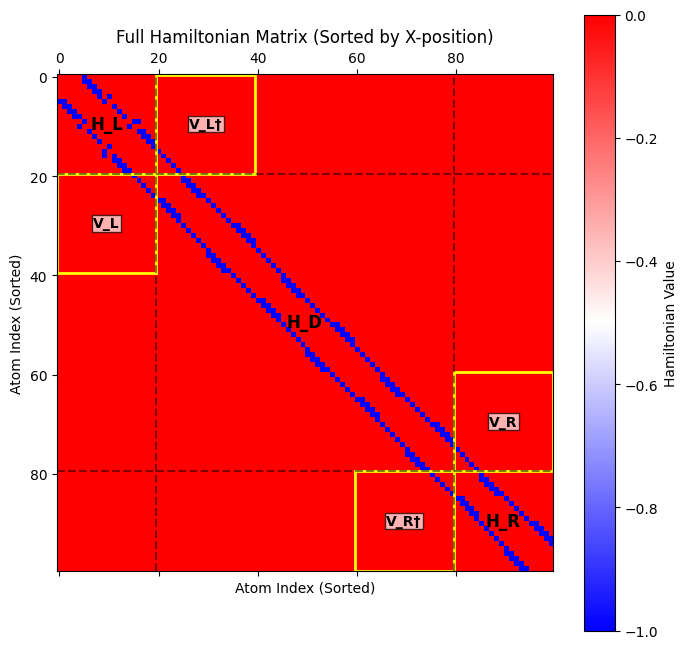

In [37]:
# --- Visualization of the Full Hamiltonian ---
import matplotlib.patches as patches

# Reconstruct the full sorted Hamiltonian for visualization
sorted_indices = np.concatenate([idx_L, idx_D, idx_R])
H_sorted = H_full[np.ix_(sorted_indices, sorted_indices)]

# Use subplots to avoid figure collision and clearer control
fig, ax = plt.subplots(figsize=(8, 8))

# Use ax.matshow instead of plt.matshow
cax = ax.matshow(H_sorted, cmap='bwr') 
fig.colorbar(cax, label='Hamiltonian Value')
ax.set_title("Full Hamiltonian Matrix (Sorted by X-position)")

# Regions info
NL = len(idx_L)
ND = len(idx_D)
NR = len(idx_R)
start_D = NL
start_R = NL + ND

# Calculate boundaries for the lines
boundary_1 = NL - 0.5
boundary_2 = start_R - 0.5

# Draw vertical lines (separating columns)
ax.axvline(x=boundary_1, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axvline(x=boundary_2, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

# Draw horizontal lines (separating rows)
ax.axhline(y=boundary_1, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axhline(y=boundary_2, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

# Label Diagonal Blocks
# Centered in each block
center_L = (NL - 1) / 2
center_D = start_D + (ND - 1) / 2
center_R = start_R + (NR - 1) / 2

ax.text(center_L, center_L, 'H_L', color='black', ha='center', va='center', fontsize=12, fontweight='bold')
ax.text(center_D, center_D, 'H_D', color='black', ha='center', va='center', fontsize=12, fontweight='bold')
ax.text(center_R, center_R, 'H_R', color='black', ha='center', va='center', fontsize=12, fontweight='bold')

# --- Highlight and Label the 4x4 Hopping Matrices ---
# n_lead_atoms determines the size of the interface coupling
vis_lead_size = n_lead_atoms 

# 1. V_L (Coupling between L and D)
# Located at intersection of D (rows) and L (cols) -> Bottom-Left of top-left cross
# Rows: start of D to start of D + 4. Cols: 0 to 4.
rect_VL = patches.Rectangle((-0.5, start_D - 0.5), vis_lead_size, vis_lead_size, linewidth=2, edgecolor='yellow', facecolor='none')
ax.add_patch(rect_VL)
ax.text(vis_lead_size/2 - 0.5, start_D + vis_lead_size/2 - 0.5, 'V_L', color='black', ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, pad=1))

# 2. V_L dagger (Coupling between D and L) - Transpose of V_L
# Rows: 0 to 4. Cols: start of D to start of D + 4.
rect_VL_dag = patches.Rectangle((start_D - 0.5, -0.5), vis_lead_size, vis_lead_size, linewidth=2, edgecolor='yellow', facecolor='none')
ax.add_patch(rect_VL_dag)
ax.text(start_D + vis_lead_size/2 - 0.5, vis_lead_size/2 - 0.5, 'V_L†', color='black', ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, pad=1))

# 3. V_R (Coupling between D and R)
# Located at intersection of D (rows) and R (cols) -> Top-Right of bottom-right cross
# Actually, t_R extracted previously connects D (rows) to R (cols)?
# Let's assume standard chain: ... -> D -> R. 
# Interaction is between END of D and START of R.
# Rows: Last 4 of D. Cols: 0 to 4 of R (which is start_R to start_R+4)
rect_VR = patches.Rectangle((start_R - 0.5, start_R - vis_lead_size - 0.5), vis_lead_size, vis_lead_size, linewidth=2, edgecolor='yellow', facecolor='none')
ax.add_patch(rect_VR)
ax.text(start_R + vis_lead_size/2 - 0.5, start_R - vis_lead_size/2 - 0.5, 'V_R', color='black', ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, pad=1))

# 4. V_R dagger
# Rows: 0 to 4 of R. Cols: Last 4 of D.
rect_VR_dag = patches.Rectangle((start_R - vis_lead_size - 0.5, start_R - 0.5), vis_lead_size, vis_lead_size, linewidth=2, edgecolor='yellow', facecolor='none')
ax.add_patch(rect_VR_dag)
ax.text(start_R - vis_lead_size/2 - 0.5, start_R + vis_lead_size/2 - 0.5, 'V_R†', color='black', ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, pad=1))

ax.set_xlabel("Atom Index (Sorted)")
ax.set_ylabel("Atom Index (Sorted)")
ax.grid(False) 
plt.show()

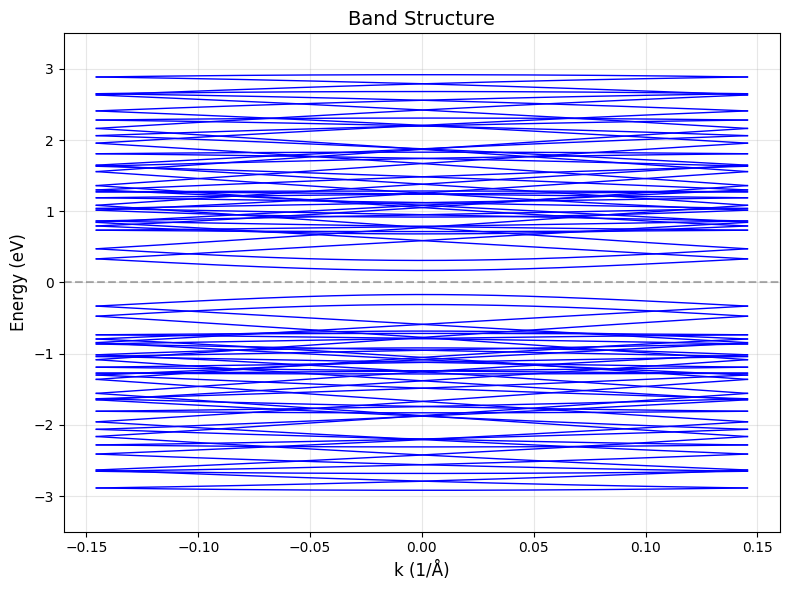

In [40]:
# Calculate bands
k_points, bands = calculate_bands(molecule, n_kpoints=400)

# Plot band structure
fig, ax = plt.subplots(figsize=(8, 6))
for band_idx in range(bands.shape[1]):
    ax.plot(k_points, bands[:, band_idx], 'b-', linewidth=1)

ax.set_xlabel('k (1/Å)', fontsize=12)
ax.set_ylabel('Energy (eV)', fontsize=12)
ax.set_title('Band Structure', fontsize=14)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.set_ylim(-3.5, 3.5)  # Set y-axis limits to see the structure better
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

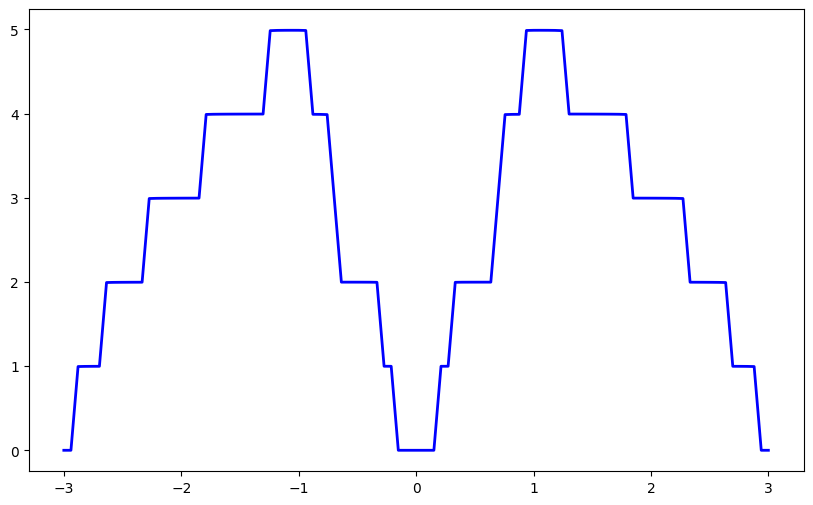

In [52]:
#Parameters:
energy_range = np.linspace(-3,3, 100)
epsilon = 0
eta = 0.0001
z = energy_range + 1j * eta


trans_val = transmission_vs_energy(H_D, H_R, t_R, H_L, t_L, energy_range, eta=0.0001)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(energy_range, trans_val, label='Transmission', color='blue', linewidth=2)



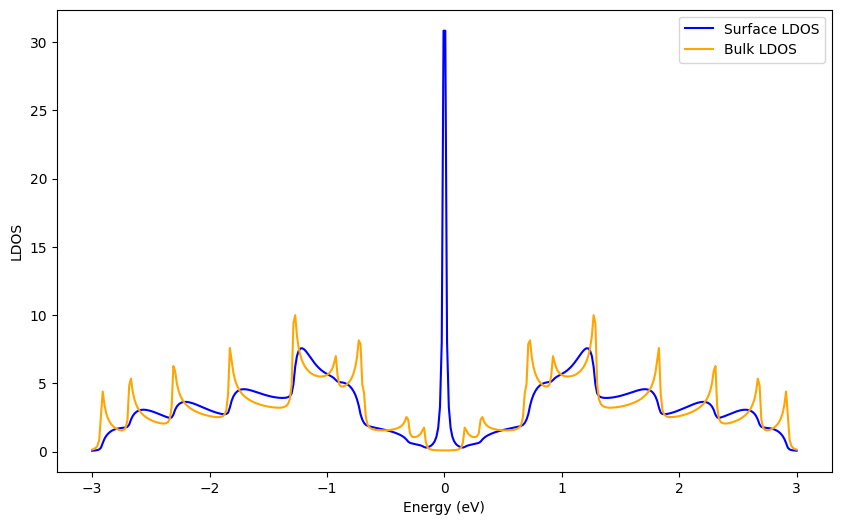

In [42]:
ldos_values, ldos_bulk_values = LDOS(H_L, t_R, energy_range)
fig, ax2 = plt.subplots(figsize=(10,6))
ax2.plot(energy_range, ldos_values, label='Surface LDOS', color='blue')
ax2.plot(energy_range, ldos_bulk_values, label='Bulk LDOS', color='orange')
ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel('LDOS')
ax2.legend()

### Now move the atoms according to Newton's laws using molecular dynamics (MD)

```text
Create a file "C.tersoff" with the following contents:

# Tersoff parameters for carbon. Based on J. Tersoff, Phys. Rev. Lett. 61, 2879 (1988)
C C C 3 1 0.0 38049 4.3484 -0.93 0.72751 1.5724e-7 2.2119 430.0 1.95 0.15 3.4879 1393.6
```

In [45]:
# Load parameter file
calc = Tersoff.from_lammps("C:\\Users\\eskil\\OneDrive\\DTU\\5.sem\\Quantum_Electronics\\C.tersoff")

# Set up calculator
structure.calc = calc # Attach Tersoff calculator based on parameters in C.tersoff

# Now based on this interatomic potential, we can get total energies and forces:
energy = structure.get_potential_energy()
forces = structure.get_forces()

print(energy, "eV")
print(forces, "eV/Å")

-153.37831020173678 eV
[[ 2.94629247e+00  0.00000000e+00 -5.10372143e+00]
 [ 0.00000000e+00  0.00000000e+00  5.99616235e-15]
 [ 0.00000000e+00  0.00000000e+00  5.99616235e-15]
 [ 0.00000000e+00  0.00000000e+00  5.99616235e-15]
 [ 2.94680618e+00  0.00000000e+00 -2.63708103e+00]
 [-2.94680618e+00  0.00000000e+00  2.63708103e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.99611702e-15]
 [ 0.00000000e+00  0.00000000e+00 -5.99611702e-15]
 [ 0.00000000e+00  0.00000000e+00 -5.99611702e-15]
 [-2.94629247e+00  0.00000000e+00  5.10372143e+00]
 [-2.94680618e+00  0.00000000e+00 -2.63708103e+00]
 [ 0.00000000e+00  0.00000000e+00  1.02140518e-14]
 [ 0.00000000e+00  0.00000000e+00  1.02140518e-14]
 [ 0.00000000e+00  0.00000000e+00  1.02140518e-14]
 [-2.94629247e+00  0.00000000e+00 -5.10372143e+00]
 [ 2.94629247e+00  0.00000000e+00  5.10372143e+00]
 [ 0.00000000e+00  0.00000000e+00 -9.76996262e-15]
 [ 0.00000000e+00  0.00000000e+00 -9.76996262e-15]
 [ 0.00000000e+00  0.00000000e+00 -9.76996262e-15]
 [ 2.946

#### Create a MD structure with fixed electrode regions

<AxesSubplot: xlabel='z, Å', ylabel='x, Å'>

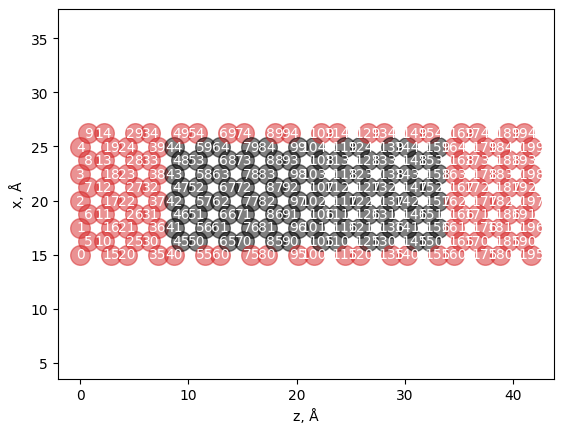

In [46]:
# First create longer [L|L|C|R|R] structure where L and R are fixed and the length of the central part (C) can be varied.
natoms_elec = len(structure)
xyz = structure.positions
lattice = structure.cell[:]
ntile = 10 # 
tiledir = 2 # tile in z
for n in range(1, ntile):
    xyz = np.concatenate((xyz, structure.positions + lattice[tiledir, :]*n))
tilemat = np.eye(3, dtype=int) # repetition matrix
tilemat[tiledir,tiledir] = ntile
lattice = tilemat @ lattice
natoms = len(xyz)
md_structure = Atoms(natoms*["C"], positions=xyz, cell=lattice, pbc=True) # Create a ASE atoms object of the repeated structure

# Fix electrode
fixed_uc = 2 # The number of electrode unit cells to fix on each side.
leftinds = list(range(0,natoms_elec*fixed_uc)) # Fix the two first unit cells
rightinds = list(range(natoms-natoms_elec*fixed_uc,natoms)) # Fix the two last unit cells

# ... and edges to simplify MD
cutoff = 1.5 # Nearest neighbor distance is d0 = 1.43877067 Å
bulk_nneighbors = 3 # In bulk graphene there are 3 nearest neighbors

i, j = neighbor_list("ij", md_structure, cutoff)
counts = np.bincount(i, minlength=len(md_structure))
edgeinds = list(np.where(counts < bulk_nneighbors)[0])

allinds = np.unique(leftinds+rightinds+edgeinds)
fixed = FixAtoms(mask=allinds)
md_structure.set_constraint(fixed) # Fix L and R electrode
draw_atoms(md_structure) # Red atoms are fixed, grey atoms are free to move

In [ ]:
view(md_structure)

<Popen: returncode: None args: ['/Users/work/miniconda3/envs/gf2026/bin/pyth...>

#### Perform MD

In [47]:
md_structure.calc = calc

temp_K = 300.0
timestep = 1.0  # Length of timestep in fs
friction = 0.01 # Friction or collision rate in 1/fs
dump = 1        # Choose how often atomic structure is saved along MD trajectory
nsteps = 1000   # Number of steps

MaxwellBoltzmannDistribution(md_structure, temperature_K=temp_K) # Set random initial velocities
dyn = Langevin(md_structure, timestep*units.fs, temperature_K=temp_K, friction=friction/units.fs, logfile='md.log') # Will append to "md.log" so you might have to delete files inbetween
dyn.attach(lambda: write('md.xyz', md_structure, append=True), interval=dump) # Will append to "md.xyz"...

dyn.run(nsteps)

Check temperature along the trajectory. There will likely be a period of equilibration, where the structure is equilibrating to the requested temperature. Therefore, I recommend you to "skip" a certain number of frames when you do the transport calculatins.

<AxesSubplot: xlabel='Time, ps', ylabel='Temperature, K'>

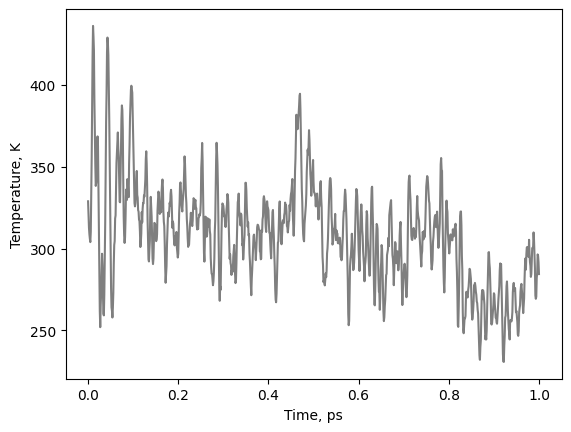

In [48]:
plot_mdlog()

In [49]:
md_traj = read("md.xyz", index=":") # Load trajectory from xyz

In [50]:
# Make sure the "correct" atoms are moving
view(md_traj)

<Popen: returncode: None args: ['c:\\Users\\eskil\\AppData\\Local\\Programs\...>

#### Calculate transmission function for snapshots

Tasks:
* Average the transmission function over trajectory and compare with "pristine" transmission calculated previously.
* Vary temperature and length of the MD region. How does the transport change? Plot and analyse how the resistance changes with MD region length. 

Tasks to do if time permits:
* Using the same MD trajectory, replace a C with N and calculate the transport properties with vibrations *and* a defect. A simple way of doing this is to change the on-site of one atom to $\epsilon \approx -2$ eV.
* Instead of averaging the transmission function over the trajectory, what happens if you average the Green's functions over time and from that effective Green's function you calculate one transmission function?

In [ ]:
rad = md_traj[200:]
a = 1.42 # C-C bond length 

for frame in rad:  
    molecule = rad[frame]
    #Sort numbering along x direction
    sorted_indices = np.argsort(molecule.positions[:, 0])
    sorted_positions = molecule.positions[sorted_indices]
    H_gra = hamiltonian(sorted_positions)
    sorted_positions = sorted_positions[np.lexsort((sorted_positions[:, 2], sorted_positions[:, 0]))]
    H_gra = hamiltonian(sorted_positions)
    indices = np.arange(len(molecule))
    positions = molecule.positions[indices]
    pos = molecule.positions[indices]
    x_sort_args = np.lexsort((pos[:, 0], pos[:, 2]))
    x_sort_args[[9, 10]] = x_sort_args[[10, 9]]
    n_lead_atoms = 20
    if len(pos) <= 2 * n_lead_atoms:
        raise ValueError(f"System too small (N={len(pos)}) to separate into Left, Device, Right with lead size {n_lead_atoms}.")
    idx_L = x_sort_args[:n_lead_atoms]
    idx_R = x_sort_args[-n_lead_atoms:]
    idx_D = x_sort_args[n_lead_atoms:-n_lead_atoms]
    H_full = hamiltonian(pos) # Calculate Hamiltonian using the molecule's positions
    H_L = H_full[np.ix_(idx_L, idx_L)]      # Hamiltonian Left
    H_D = H_full[np.ix_(idx_D, idx_D)]      # Hamiltonian Device
    H_R = H_full[np.ix_(idx_R, idx_R)]      # Hamiltonian Right
    t_L = H_full[np.ix_(idx_D[:n_lead_atoms], idx_L)]      
    t_R = H_full[np.ix_(idx_D[-n_lead_atoms:], idx_R)]     
    
     

1001

<Axes: xlabel='z, Å', ylabel='x, Å'>

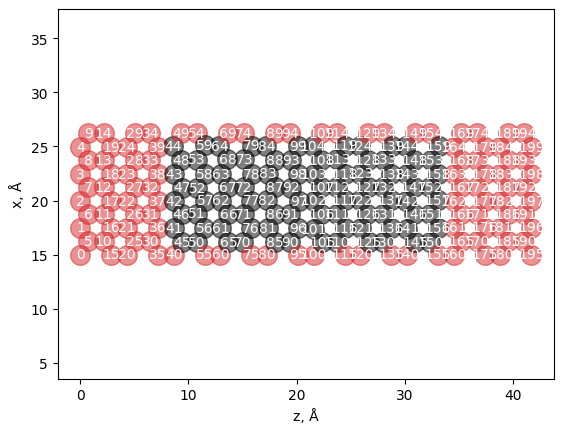

In [ ]:
frame = md_traj[49] # To load e.g., 50th frame
draw_atoms(frame)

In [ ]:
# Calculate transmission